# Empirical, anecdotal analysis of `mainnnet` mempool consistency

**<font color="red">PRELIMINARY, PARTIAL DRAFT: WORK IN PROGRESS</font>**

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Hourly summary

In [2]:
mempoolHourly <- fread("mempool-hourly.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHourly) <- c("Region", "Time", "Tx first seen", "Tx count", "Tx fraction")
mempoolHourly %>% summary

            Region        Time                        Tx first seen  
 ap-northeast-1:14   Min.   :2025-11-19 21:00:00.00   Mode :logical  
 eu-central-1  :92   1st Qu.:2025-11-20 12:00:00.00   FALSE:66       
 us-east-2     :13   Median :2025-11-21 03:00:00.00   TRUE :53       
                     Mean   :2025-11-21 02:22:11.08                  
                     3rd Qu.:2025-11-21 18:00:00.00                  
                     Max.   :2025-11-22 00:00:00.00                  
    Tx count       Tx fraction     
 Min.   :   1.0   Min.   :0.00113  
 1st Qu.:  13.5   1st Qu.:0.01175  
 Median : 885.0   Median :0.85103  
 Mean   : 768.0   Mean   :0.56303  
 3rd Qu.:1247.0   3rd Qu.:0.99391  
 Max.   :5138.0   Max.   :1.00000  

### Hourly fraction of transactions preceding the block

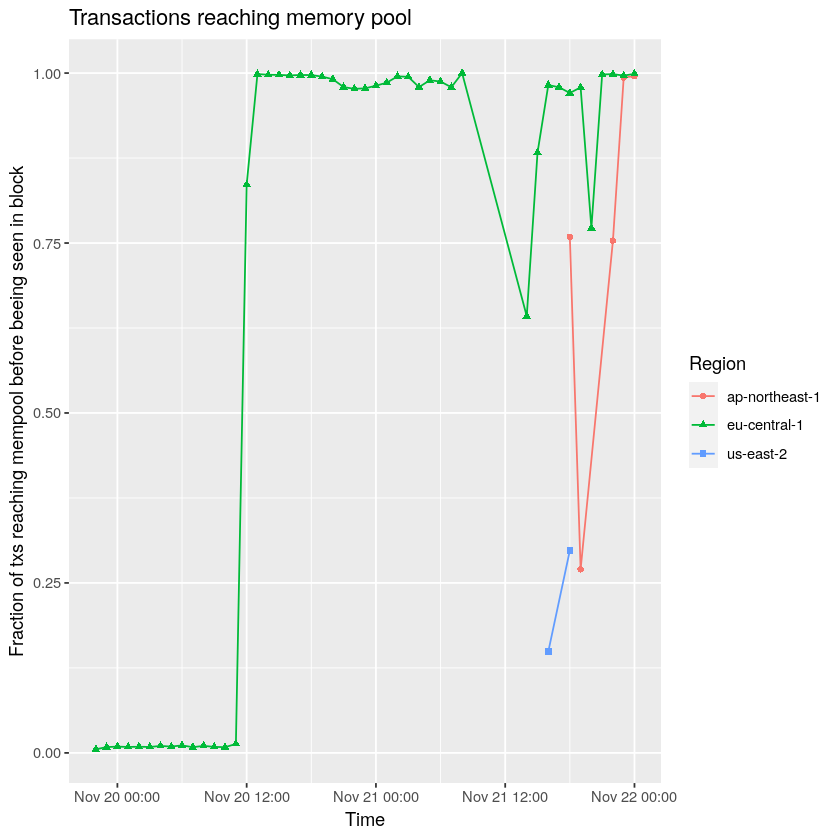

In [3]:
ggplot(mempoolHourly[`Tx first seen` == TRUE], aes(x=`Time`, y=`Tx fraction`, color=`Region`, shape=`Region`)) +
    geom_line() +
    geom_point() +
    ylab("Fraction of txs reaching mempool before beeing seen in block") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [4]:
ggsave("mempool-hourly.png", units="in", dpi=150, width=8, height=6)

## Mempool history

In [5]:
mempoolHistory <- fread("mempool-history.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHistory) <- c("Region", "Slot", "Tx seen first", "Tx count")
mempoolHistory %>% summary

            Region          Slot           Tx seen first      Tx count     
 ap-northeast-1:1172   Min.   :172020938   Mode :logical   Min.   :  1.00  
 eu-central-1  :6885   1st Qu.:172070320   FALSE:4284      1st Qu.:  3.00  
 us-east-2     :1059   Median :172118316   TRUE :4832      Median :  7.00  
                       Mean   :172121027                   Mean   : 10.02  
                       3rd Qu.:172183672                   3rd Qu.: 13.00  
                       Max.   :172206016                   Max.   :122.00  

In [6]:
mempoolHistory[, `Tx fraction` := as.numeric(`Tx count`) / sum(`Tx count`), by =.(`Region`, `Slot`)]

### Histogram of slot-by-slot fraction of transactions preceding the block (nonlinear scale)

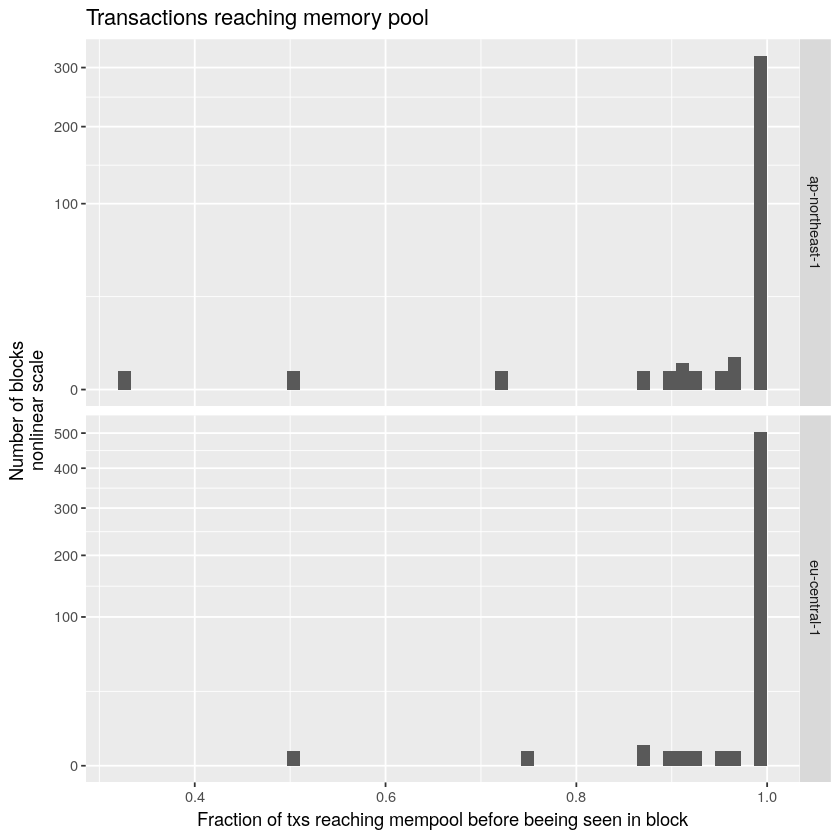

In [7]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    scale_y_sqrt() +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks\nnonlinear scale") +
    ggtitle(
        "Transactions reaching memory pool"
    )

### Histogram of slot-by-slot fraction of transactions preceding the block

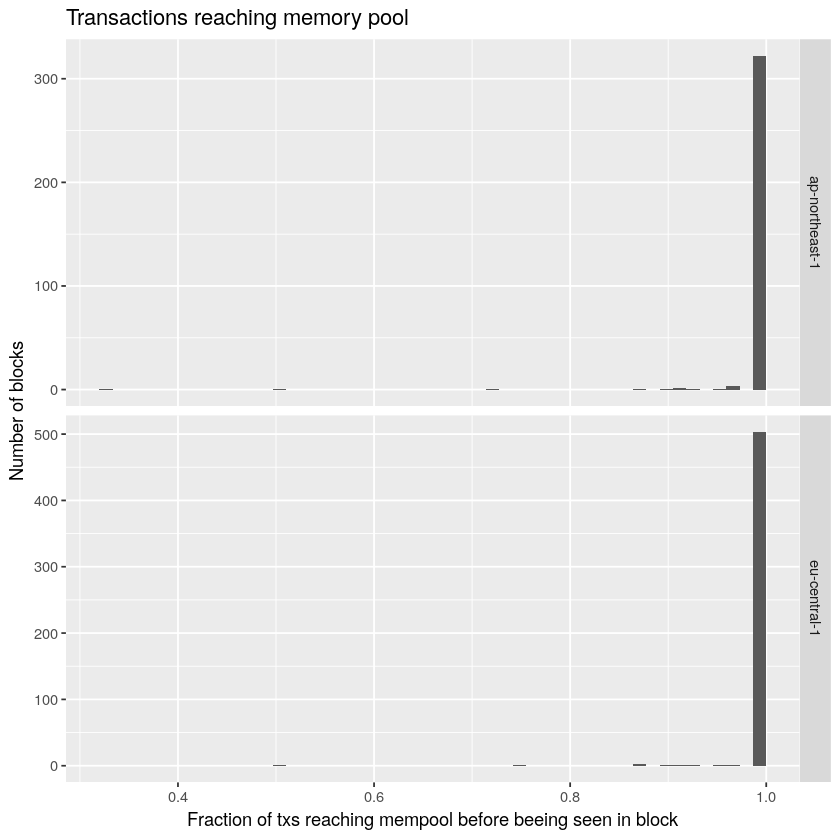

In [8]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [9]:
ggsave("mempool-history.png", units="in", dpi=150, width=8, height=6)

## Mempool vs blocks

In [10]:
mempoolBlocks <- fread("mempool-vs-blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first")
mempoolBlocks %>% summary

            Region           Slot          
 ap-northeast-1:14148   Min.   :172020938  
 eu-central-1  :63969   1st Qu.:172089258  
 us-east-2     :13270   Median :172136323  
                        Mean   :172130751  
                        3rd Qu.:172183306  
                        Max.   :172206016  
                                           
                                                            Block hash   
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:  237  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:  224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:  222  
 ad8c59a6ae59ad5c49071cd49a8a21944555cbdbc695d9c47c4081bbb78fe78a:  183  
 fb40a3b7b7345173b8fcaa6799c653ee6c4db821407b57598cfb3cc076b59686:  177  
 10fe42ba07c542e7152d958496d767e8244556bee5725324b0aec852ff325b7f:  168  
 (Other)                                                         :90176  
                                                        

### Histogram of transaction arrival time relative to slot

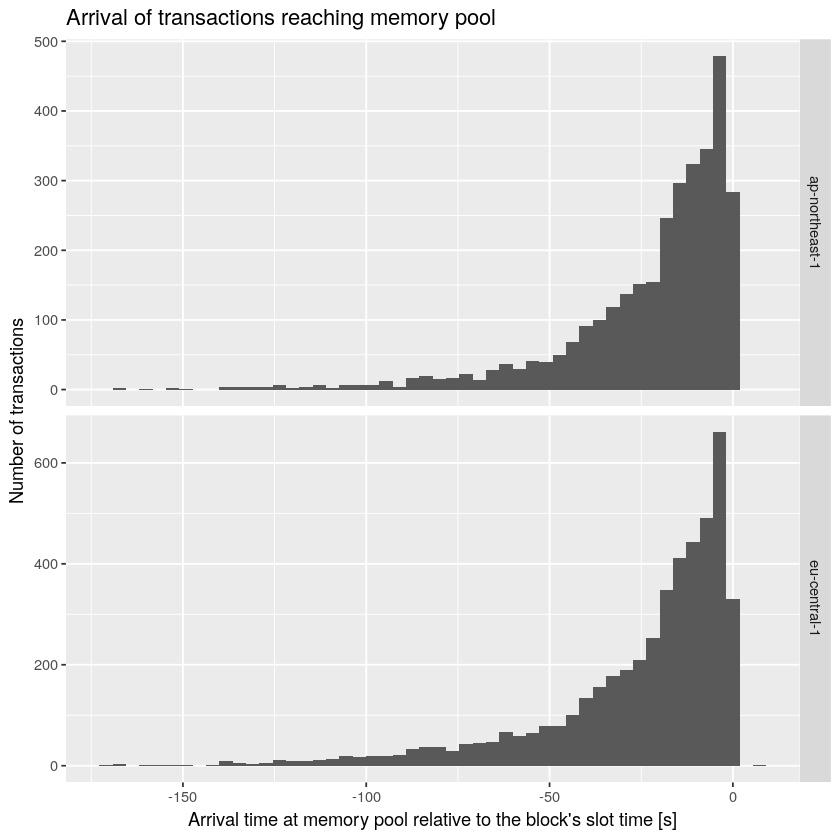

In [11]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600  & `Tx seen first` == TRUE], aes(x=`Mempool - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival of transactions reaching memory pool"
    )

In [12]:
ggsave("transaction-arrival.png", units="in", dpi=150, width=8, height=6)

### Histogram of block arrival time relative to slot

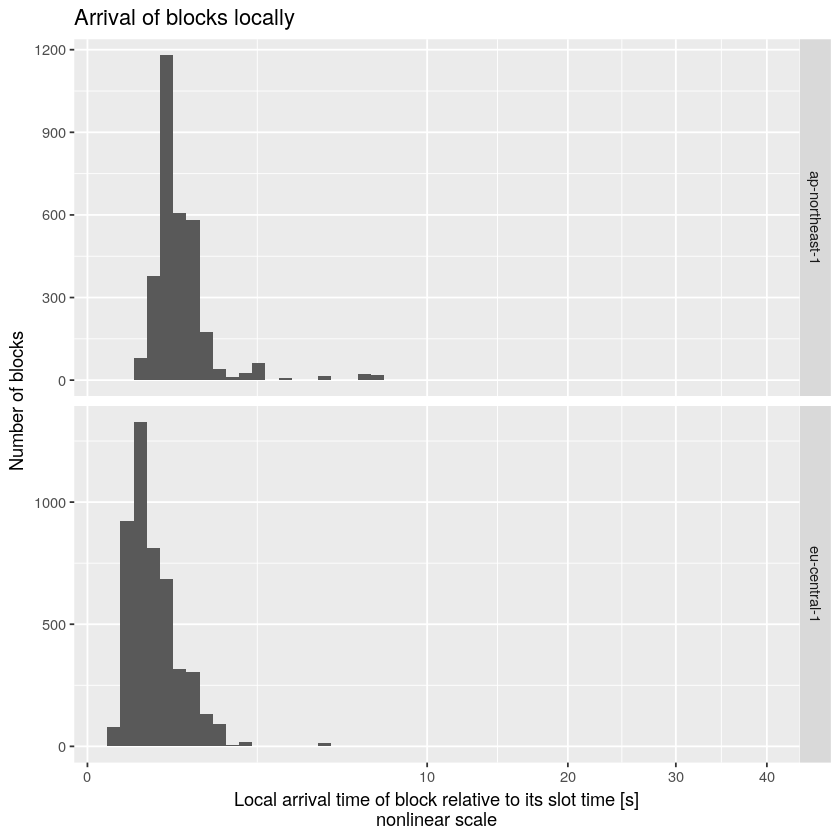

In [13]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Block - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    scale_x_sqrt() +
    xlab("Local arrival time of block relative to its slot time [s]\nnonlinear scale") +
    ylab("Number of blocks") +
    ggtitle(
        "Arrival of blocks locally"
    )

In [14]:
ggsave("block-arrival.png", units="in", dpi=150, width=8, height=6)